<a href="https://colab.research.google.com/github/c-w-m/btap/blob/master/ch01/First_Insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[**Blueprints for Text Analysis Using Python**](https://github.com/blueprints-for-text-analytics-python/blueprints-text)  
Jens Albrecht, Sidharth Ramachandran, Christian Winkler

# Chapter 1:<div class='tocSkip'/>

# Gaining Early Insights from Textual Data

## Remark<div class='tocSkip'/>

The code in this notebook differs slightly from the printed book. For example we frequently use pretty print (`pp.pprint`) instead of `print` and `tqdm`'s `progress_apply` instead of Pandas' `apply`. 

Moreover, several layout and formatting commands, like `figsize` to control figure size or subplot commands are removed in the book.

You may also find some lines marked with three hashes ###. Those are not in the book as well as they don't contribute to the concept.

All of this is done to simplify the code in the book and put the focus on the important parts instead of formatting.

## Setup<div class='tocSkip'/>

Set directory locations. If working on Google Colab: copy files and install required libraries.

In [1]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/c-w-m/btap.git/raw/master'
    os.system(f'wget {GIT_ROOT}/ch01/setup.py')

%run -i setup.py

You are working on a local system.
Files will be searched relative to "..".


## Load Python Settings<div class="tocSkip"/>

Common imports, defaults for formatting in Matplotlib, Pandas etc.

In [2]:
%run "$BASE_DIR/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

## What you will learn and what we will build


# Exploratory Data Analysis


# Introducing the Dataset


In [3]:
pd.options.display.max_colwidth = 150 ###
file = "un-general-debates-blueprint.csv"
file = f"{BASE_DIR}/data/un-general-debates/un-general-debates-blueprint.csv.gz" ### real location
df = pd.read_csv(file)
df.sample(2, random_state=53)

,session,year,country,country_name,speaker,position,text
3871,51,1996,PER,Peru,Francisco Tudela Van Breughel Douglas,Minister for Foreign Affairs,"﻿At the outset, allow me,\nSir, to convey to you and to this Assembly the greetings\nand congratulations of the Peruvian people, as well as\ntheir..."
4697,56,2001,GBR,United Kingdom,Jack Straw,Minister for Foreign Affairs,"﻿Please allow me\nwarmly to congratulate you, Sir, on your assumption of\nthe presidency of the fifty-sixth session of the General\nAssembly.\nThi..."


# Blueprint: Getting an Overview of the Data with Pandas


## Calculating Summary Statistics for Columns


In [4]:
df['length'] = df['text'].str.len()

df.describe().T

,count,mean,std,min,25%,50%,75%,max
session,7507.00,49.61,12.89,25.00,39.00,51.00,61.00,70.00
year,7507.00,1994.61,12.89,1970.00,1984.00,1996.00,2006.00,2015.00
length,7507.00,17967.28,7860.04,2362.00,12077.00,16424.00,22479.50,72041.00


In [5]:
df[['country', 'speaker']].describe(include='O').T

,count,unique,top,freq
country,7507,199,TUN,46
speaker,7480,5428,Seyoum Mesfin,12


## Checking for Missing Data


In [6]:
df.isna().sum()

session            0
year               0
country            0
country_name       0
speaker           27
position        3005
text               0
length             0
dtype: int64

In [7]:
df['speaker'].fillna('unkown', inplace=True)

In [8]:
df[df['speaker'].str.contains('Bush')]['speaker'].value_counts()

George W. Bush        4
Mr. George W. Bush    2
George Bush           1
Mr. George W Bush     1
Bush                  1
Name: speaker, dtype: int64

## Plotting Value Distributions


<AxesSubplot:>

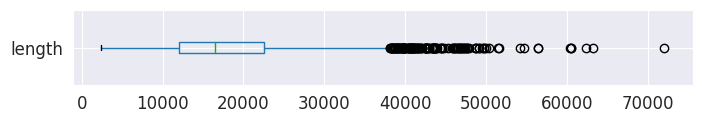

In [9]:
df['length'].plot(kind='box', vert=False, figsize=(8, 1))

<AxesSubplot:ylabel='Frequency'>

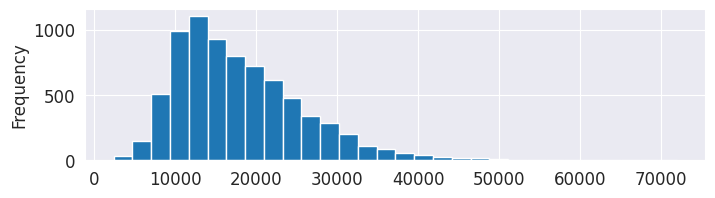

In [10]:
df['length'].plot(kind='hist', bins=30, figsize=(8,2))

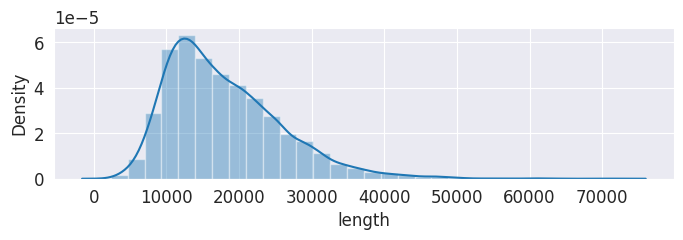

In [11]:
# Not in book: seaborn plot with gaussian kernel density estimate
import seaborn as sns

plt.figure(figsize=(8, 2))
sns.distplot(df['length'], bins=30, kde=True);

## Comparing Value Distributions across Categories


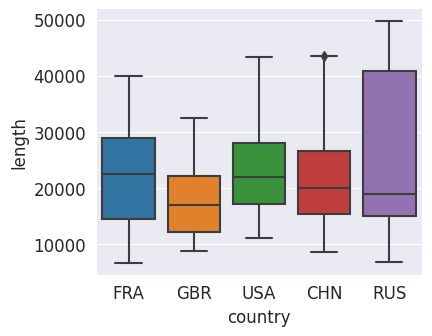

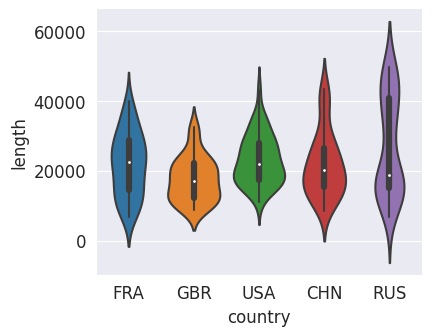

In [12]:
where = df['country'].isin(['USA', 'FRA', 'GBR', 'CHN', 'RUS'])
g = sns.catplot(data=df[where], x="country", y="length", kind='box')
g.fig.set_size_inches(4, 3) ###
g.fig.set_dpi(100) ###
g = sns.catplot(data=df[where], x="country", y="length", kind='violin')
g.fig.set_size_inches(4, 3) ###
g.fig.set_dpi(100) ###

## Visualizing Developments over Time


<AxesSubplot:title={'center':'Number of Countries'}, xlabel='year'>

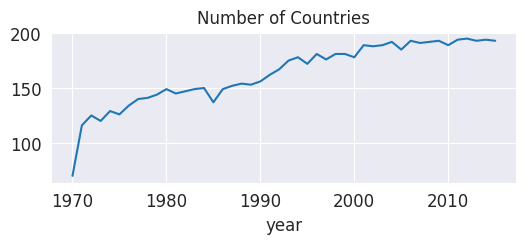

In [13]:
df.groupby('year').size().plot(title="Number of Countries", figsize=(6,2))

<AxesSubplot:title={'center':'Avg. Speech Length'}, xlabel='year'>

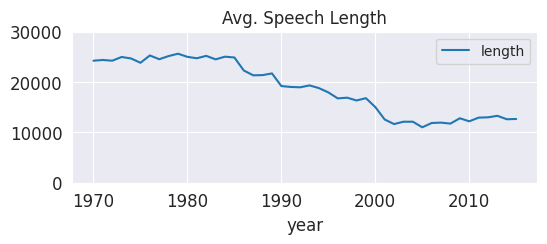

In [14]:
df.groupby('year').agg({'length': 'mean'}) \
  .plot(title="Avg. Speech Length", ylim=(0,30000), figsize=(6,2))

# Blueprint: Building a Simple Text Preprocessing Pipeline


## Tokenization with Regular Expressions


In [15]:
import regex as re

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [16]:
text = "Let's defeat SARS-CoV-2 together in 2020!"
tokens = tokenize(text)
print("|".join(tokens))

Let|s|defeat|SARS-CoV-2|together|in


## Treating Stop Words


In [17]:
import nltk
# not in book: make sure stop words are available
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/cwm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
import nltk

stopwords = set(nltk.corpus.stopwords.words('english'))

In [19]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [20]:
include_stopwords = {'dear', 'regards', 'must', 'would', 'also'}
exclude_stopwords = {'against'}

stopwords |= include_stopwords
stopwords -= exclude_stopwords

## Processing a Pipeline with one Line of Code


In [21]:
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [22]:
df['tokens'] = df['text'].progress_apply(prepare, pipeline=pipeline)

  0%|          | 0/7507 [00:00<?, ?it/s]

In [23]:
df['num_tokens'] = df['tokens'].progress_map(len)

  0%|          | 0/7507 [00:00<?, ?it/s]

# Blueprints for Word Frequency Analysis


## Blueprint: Counting Words with a Counter


In [24]:
from collections import Counter

tokens = tokenize("She likes my cats and my cats like my sofa.")

counter = Counter(tokens)
print(counter)

Counter({'my': 3, 'cats': 2, 'She': 1, 'likes': 1, 'and': 1, 'like': 1, 'sofa': 1})


In [25]:
more_tokens = tokenize("She likes dogs and cats.")
counter.update(more_tokens)
print(counter)

Counter({'my': 3, 'cats': 3, 'She': 2, 'likes': 2, 'and': 2, 'like': 1, 'sofa': 1, 'dogs': 1})


In [26]:
counter = Counter()

_ = df['tokens'].map(counter.update)

In [27]:
pp.pprint(counter.most_common(5))

[('nations', 124508),
 ('united', 120763),
 ('international', 117223),
 ('world', 89421),
 ('countries', 85734)]


In [28]:
from collections import Counter ###
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].progress_map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [29]:
freq_df = count_words(df)
freq_df.head(5)

  0%|          | 0/7507 [00:00<?, ?it/s]

,freq
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734


In [30]:
# top words with 10+ characters
count_words(df, column='text', 
            preprocess=lambda text: re.findall(r"\w{10,}", text)).head(5)

  0%|          | 0/7507 [00:00<?, ?it/s]

,freq
token,
international,106974
development,51334
Government,35528
Organization,33763
developing,25177


## Blueprint: Creating a Frequency Diagram


[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

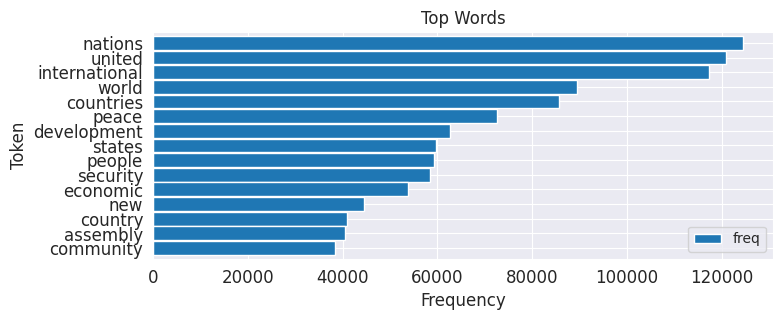

In [31]:
ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

## Blueprint: Creating Word Clouds


(-0.5, 399.5, 199.5, -0.5)

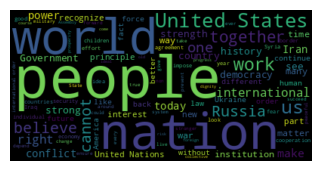

In [32]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

text = df.query("year==2015 and country=='USA'")['text'].values[0]

plt.figure(figsize=(4, 2)) ###
wc = WordCloud(max_words=100, stopwords=stopwords)
wc.generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

In [33]:
from wordcloud import WordCloud ###
from collections import Counter ###

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

  0%|          | 0/193 [00:00<?, ?it/s]

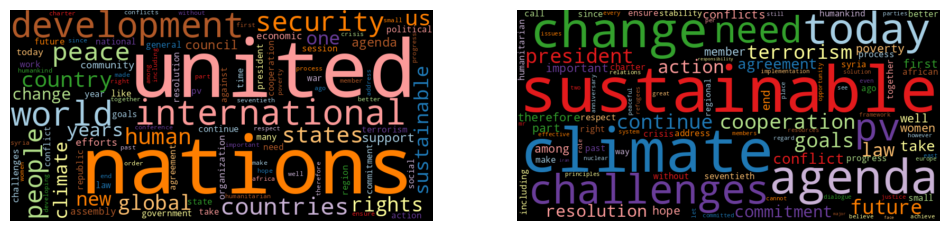

In [34]:
freq_2015_df = count_words(df[df['year']==2015])
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)###
wordcloud(freq_2015_df['freq'], max_words=100)
plt.subplot(1,2,2)###
wordcloud(freq_2015_df['freq'], max_words=100, stopwords=freq_df.head(50).index)
#plt.tight_layout()###

## Blueprint: Ranking with TF-IDF


In [35]:
def compute_idf(df, column='tokens', preprocess=None, min_df=2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # count tokens
    counter = Counter()
    df[column].progress_map(update)

    # create data frame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df

In [36]:
idf_df = compute_idf(df)

  0%|          | 0/7507 [00:00<?, ?it/s]

In [37]:
# Not in book: sample of IDF values
# high IDF means rare (interesting) term
idf_df.sample(5)

,df,idf
token,,
ellsworth,3,7.92
imperiled,27,5.73
in-shore,2,8.33
radius,5,7.41
encountered,300,3.32


In [38]:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

In [39]:
# not in book: for more data: joining is faster
freq_df = freq_df.join(idf_df)
freq_df['tfidf'] = freq_df['freq'] * freq_df['idf']

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

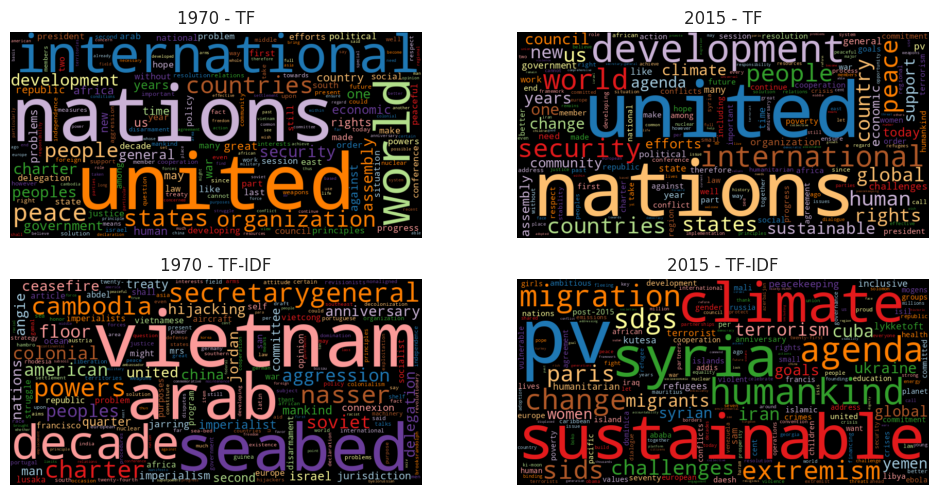

In [40]:
freq_1970 = count_words(df[df['year'] == 1970])
freq_2015 = count_words(df[df['year'] == 2015])

freq_1970['tfidf'] = freq_1970['freq'] * idf_df['idf']
freq_2015['tfidf'] = freq_2015['freq'] * idf_df['idf']

plt.figure(figsize=(12,6)) ###
#wordcloud(freq_df['freq'], title='All years', subplot=(1,3,1))
plt.subplot(2,2,1)###
wordcloud(freq_1970['freq'], title='1970 - TF', 
          stopwords=['twenty-fifth', 'twenty-five'])
plt.subplot(2,2,2)###
wordcloud(freq_2015['freq'], title='2015 - TF', 
          stopwords=['seventieth'])
plt.subplot(2,2,3)###
wordcloud(freq_1970['tfidf'], title='1970 - TF-IDF', 
          stopwords=['twenty-fifth', 'twenty-five', 'twenty', 'fifth'])
plt.subplot(2,2,4)###
wordcloud(freq_2015['tfidf'], title='2015 - TF-IDF', 
          stopwords=['seventieth'])

# Blueprint: Finding a Keyword in Context (KWIC)


In [41]:
from textacy.text_utils import KWIC

def kwic(doc_series, keyword, window=35, print_samples=5):

    def add_kwic(text):
        kwic_list.extend(KWIC(text, keyword, ignore_case=True, 
                              window_width=window, print_only=False))

    kwic_list = []
    doc_series.progress_map(add_kwic)

    if print_samples is None or print_samples==0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)} " + \
              f"contexts for '{keyword}':")
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0])+'  '+ \
                  sample[1]+'  '+\
                  re.sub(r'[\n\t]', ' ', sample[2]))

In [42]:
random.seed(22) ###
kwic(df[df['year'] == 2015]['text'], 'sdgs', print_samples=5)

  0%|          | 0/193 [00:00<?, ?it/s]

5 random samples out of 73 contexts for 'sdgs':
 of our planet and its people. The   SDGs   are a tangible manifestation of th
nd, we are expected to achieve the   SDGs   and to demonstrate dramatic develo
ead by example in implementing the   SDGs   in Bangladesh. Attaching due impor
the Sustainable Development Goals (  SDGs  ). We applaud all the Chairs of the
new Sustainable Development Goals (  SDGs  ) aspire to that same vision. The A


# Blueprint: Analyzing N-Grams


In [43]:
def ngrams(tokens, n=2, sep=' '):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

text = "the visible manifestation of the global climate change"
tokens = tokenize(text)
print("|".join(ngrams(tokens, 2)))

the visible|visible manifestation|manifestation of|of the|the global|global climate|climate change


In [44]:
def ngrams(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
            if len([t for t in ngram if t in stopwords])==0]

print("Bigrams:", "|".join(ngrams(tokens, 2, stopwords=stopwords)))
print("Trigrams:", "|".join(ngrams(tokens, 3, stopwords=stopwords)))

Bigrams: visible manifestation|global climate|climate change
Trigrams: global climate change


In [45]:
df['bigrams'] = df['text'].progress_apply(prepare, pipeline=[str.lower, tokenize]) \
                          .progress_apply(ngrams, n=2, stopwords=stopwords)

count_words(df, 'bigrams').head(5)

  0%|          | 0/7507 [00:00<?, ?it/s]

  0%|          | 0/7507 [00:00<?, ?it/s]

  0%|          | 0/7507 [00:00<?, ?it/s]

,freq
token,
united nations,103236
international community,27786
general assembly,27096
security council,20961
human rights,19856


In [46]:
idf_df = compute_idf(df) ### re-initialize to be safe
# concatenate existing IDF data frame with bigram IDFs
idf_df = pd.concat([idf_df, compute_idf(df, 'bigrams', min_df=10)])

freq_df = count_words(df[df['year'] == 2015], 'bigrams')
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

  0%|          | 0/7507 [00:00<?, ?it/s]

  0%|          | 0/7507 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

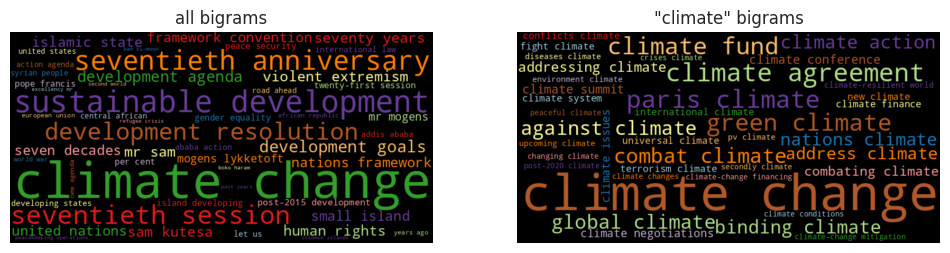

In [47]:
plt.figure(figsize=(12,6)) ###
plt.subplot(1,2,1) ###
wordcloud(freq_df['tfidf'], title='all bigrams', max_words=50)

plt.subplot(1,2,2) ###
# plt.tight_layout() ###
where = freq_df.index.str.contains('climate')
wordcloud(freq_df[where]['freq'], title='"climate" bigrams', max_words=50)

# Blueprint: Comparing Frequencies across Time-Intervals and Categories


## Creating Frequency Timelines


In [48]:
def count_keywords(tokens, keywords): 
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]

In [49]:
keywords = ['nuclear', 'terrorism', 'climate', 'freedom']
tokens = ['nuclear', 'climate', 'climate', 'freedom', 'climate', 'freedom']

print(count_keywords(tokens, keywords))

[1, 0, 3, 2]


In [50]:
def count_keywords_by(df, by, keywords, column='tokens'):
    
    freq_matrix = df[column].progress_apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    freq_df[by] = df[by] # copy the grouping column(s)
    
    return freq_df.groupby(by=by).sum().sort_values(by)

In [51]:
freq_df = count_keywords_by(df, by='year', keywords=keywords)

  0%|          | 0/7507 [00:00<?, ?it/s]

In [52]:
pd.options.display.max_rows = 4

In [53]:
pd.options.display.max_rows = 60

<AxesSubplot:xlabel='year'>

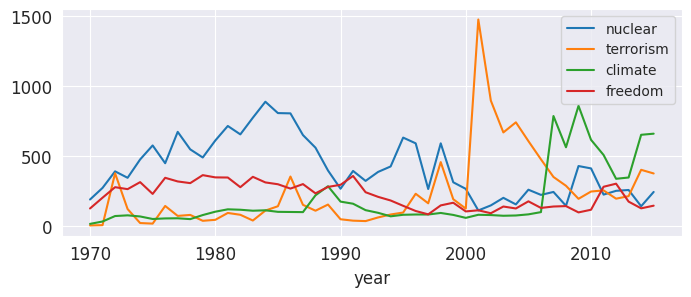

In [54]:
freq_df.plot(kind='line', figsize=(8, 3))

In [55]:
random.seed(23) ###
# analyzing mentions of 'climate' before 1980
kwic(df.query('year < 1980')['text'], 'climate', window=35, print_samples=5)

  0%|          | 0/1245 [00:00<?, ?it/s]

5 random samples out of 581 contexts for 'climate':
ation with a view to replacing the   climate   of fear, mistrust and hatred by to
ntributing to the maintenance of a   climate   of peace, harmony and understandin
ges in the international political   climate  . There is increasing awareness of 
rian-Israeli front, have created a   climate   which favors the continuation of n
 that, far from noting a promising   climate   in the most critical areas of inte


## Creating Frequency Heat Maps


  0%|          | 0/7507 [00:00<?, ?it/s]

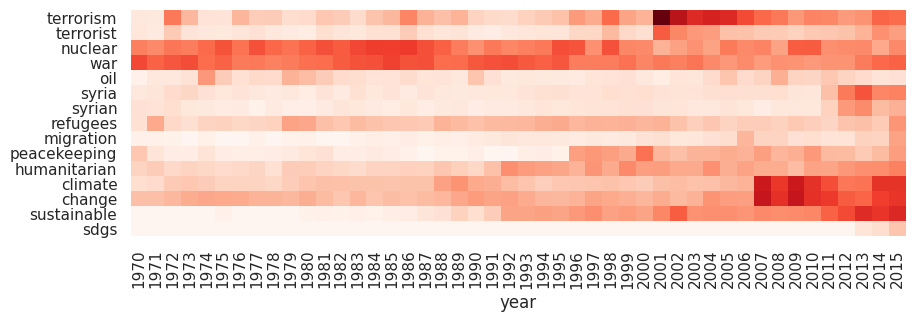

In [56]:
keywords = ['terrorism', 'terrorist', 'nuclear', 'war', 'oil',
            'syria', 'syrian', 'refugees', 'migration', 'peacekeeping', 
            'humanitarian', 'climate', 'change', 'sustainable', 'sdgs']  

freq_df = count_keywords_by(df, by='year', keywords=keywords)

# compute relative frequencies based on total number of tokens per year
freq_df = freq_df.div(df.groupby('year')['num_tokens'].sum(), axis=0)
# apply square root as sublinear filter for better contrast
freq_df = freq_df.apply(np.sqrt)

plt.figure(figsize=(10, 3)) ###
sns.set(font_scale=1) ###
sns.heatmap(data=freq_df.T, 
            xticklabels=True, yticklabels=True, cbar=False, cmap="Reds")
sns.set(font_scale=1) ###

# Closing Remarks
